# Human Pose Estimation and instance-level Human Parsing for Virtual Try-On

This project was developed as part of the Computer Vision exam at the University of Padova. Our group:  

- **Segato Pietro** (2122209)  
- **Vezzosi Giacomo** (2104369)  
- **Vitali Giovanni** (2119998)

## Execution Environment  
This notebook is designed to be executed on **Google Colab** to ensure compatibility with the necessary dependencies and GPU acceleration. Before running the code, ensure that the runtime environment is set to **GPU** (Runtime → Change runtime type → GPU).


# VITON-HD Repository and Dependencies

In this section, we provide an overview of the repository used for our project and the necessary dependencies for running the code. Our work is based on the VITON-HD implementation, which we cloned from the official GitHub repository.

## Repository Details

The VITON-HD repository was cloned from the following GitHub link:  
[https://github.com/shadow2496/VITON-HD.git](https://github.com/shadow2496/VITON-HD.git).
> Shadow2496. *VITON-HD: Virtual Try-On with High-Resolution Image Generation*. GitHub repository, 2021. [https://github.com/shadow2496/VITON-HD](https://github.com/shadow2496/VITON-HD.git).

This repository provides an implementation of virtual try-on technology that aims to try on garments on human images. For our Computer Vision exam project, we adapted this repository to work with the official viton-hd-resized dataset and our testing pipeline.

All dependencies and scripts from the repository have been integrated into our workflow.


In [1]:
import os
from google.colab import files as colab_files
import gdown
import zipfile
import glob
from PIL import Image
from IPython.display import display
import shutil

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
!pip install opencv-python torchgeometry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
!git clone https://github.com/shadow2496/VITON-HD.git

Cloning into 'VITON-HD'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 49 (delta 10), reused 7 (delta 6), pack-reused 31 (from 1)
Receiving objects: 100% (49/49), 5.03 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [3]:
# Official files download, pre-trained weights and datasets
files_to_download = [
    # Datasets
    {
        "id": "1ZA2C8yMOprwc0TV4hvrt0X-ljZugrClq",
        "destination": "./VITON-HD/datasets/test.zip"
    },
    {
        "id": "1ncEHn_6liOot8sgt3A2DOFJBffvx8tW8",
        "destination": "./VITON-HD/datasets/test_pairs.txt"
    },
    # Model checkpoints
    {
        "id": "17U1sooR3mVIbe8a7rZuFIF3kukPchHfZ",
        "destination": "./VITON-HD/checkpoints/seg_final.pth"
    },
    {
        "id": "1MBHBddaAs7sy8W40jzLmNL83AUh035F1",
        "destination": "./VITON-HD/checkpoints/gmm_final.pth"
    },
    {
        "id": "1RM4OthSM6V4r7kWCu8SbPIPY14Oz8B2u",
        "destination": "./VITON-HD/checkpoints/alias_final.pth"
    },
]

# Download file
for file in files_to_download:
    print(f"Downloading {file['destination']}...")
    gdown.download(f"https://drive.google.com/uc?id={file['id']}", file["destination"], quiet=False)

    if file["destination"].endswith(".zip"):
        print(f"Unzip {file['destination']}...")
        with zipfile.ZipFile(file["destination"], 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(file["destination"]))
        print(f"Unzip completed {file['destination']}!")

print("Download completed")

Downloading...
From: https://drive.google.com/uc?id=1ZA2C8yMOprwc0TV4hvrt0X-ljZugrClq
To: /content/VITON-HD/datasets/test.zip
100%|██████████| 2.69M/2.69M [00:00<00:00, 83.4MB/s]


Unzip ./VITON-HD/datasets/test.zip...
Unzip completed ./VITON-HD/datasets/test.zip!


Downloading...
From: https://drive.google.com/uc?id=1ncEHn_6liOot8sgt3A2DOFJBffvx8tW8
To: /content/VITON-HD/datasets/test_pairs.txt
100%|██████████| 156/156 [00:00<00:00, 357kB/s]


Downloading...
From (original): https://drive.google.com/uc?id=17U1sooR3mVIbe8a7rZuFIF3kukPchHfZ
From (redirected): https://drive.google.com/uc?id=17U1sooR3mVIbe8a7rZuFIF3kukPchHfZ&confirm=t&uuid=d1cc3656-81c6-465f-a1ba-19b95a64c351
To: /content/VITON-HD/checkpoints/seg_final.pth
100%|██████████| 138M/138M [00:02<00:00, 68.7MB/s]


Downloading...
From: https://drive.google.com/uc?id=1MBHBddaAs7sy8W40jzLmNL83AUh035F1
To: /content/VITON-HD/checkpoints/gmm_final.pth
100%|██████████| 76.2M/76.2M [00:00<00:00, 161MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1RM4OthSM6V4r7kWCu8SbPIPY14Oz8B2u
From (redirected): https://drive.google.com/uc?id=1RM4OthSM6V4r7kWCu8SbPIPY14Oz8B2u&confirm=t&uuid=91cb76ac-040e-4913-8005-df379ff83ea5
To: /content/VITON-HD/checkpoints/alias_final.pth
100%|██████████| 402M/402M [00:03<00:00, 134MB/s]

Download completed


In [4]:
%cd /content/VITON-HD

/content/VITON-HD


# Testing and Inference  

In this section, we perform a preliminary test run to evaluate the VITON-HD model's ability to generate a virtual try-on output. Specifically, the model removes the original clothing from a person in the dataset and synthesizes a new image where the subject is wearing a selected cloth. This process involves:  

1. **Segmentation-based Clothing Removal:** The model extracts and processes the human parsing map to eliminate the original clothing.  
2. **Warping and Alignment:** The target garment is warped to fit the body shape using a geometric matching module (GMM).  
3. **Image Synthesis:** The ALIAS Generator reconstructs the final image with realistic blending of the new clothing.  

This test ensures that the pipeline functions correctly before proceeding with further evaluations.


In [5]:
# Config file, images and clothing can be changed
config_content = """
08909_00.jpg 02783_00.jpg
00891_00.jpg 01430_00.jpg
03615_00.jpg 09933_00.jpg
07445_00.jpg 06429_00.jpg
07573_00.jpg 11791_00.jpg
10549_00.jpg 01260_00.jpg
"""

# test pairs path
config_path = "datasets/test/test_pairs.txt"

# Write selected pairs to test
with open(config_path, "w") as file:
    file.write(config_content)

print(f"Successfully overwritten: {config_path}")

Successfully overwritten: datasets/test/test_pairs.txt


Namespace(name='default_test', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/content/VITON-HD/utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary co

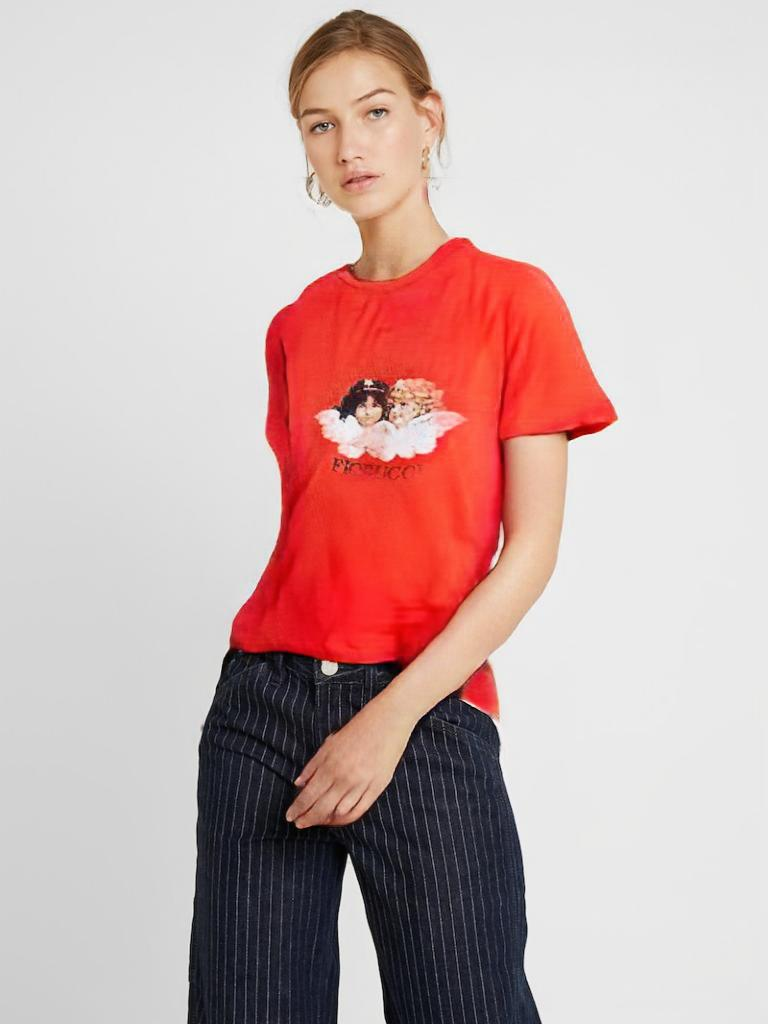

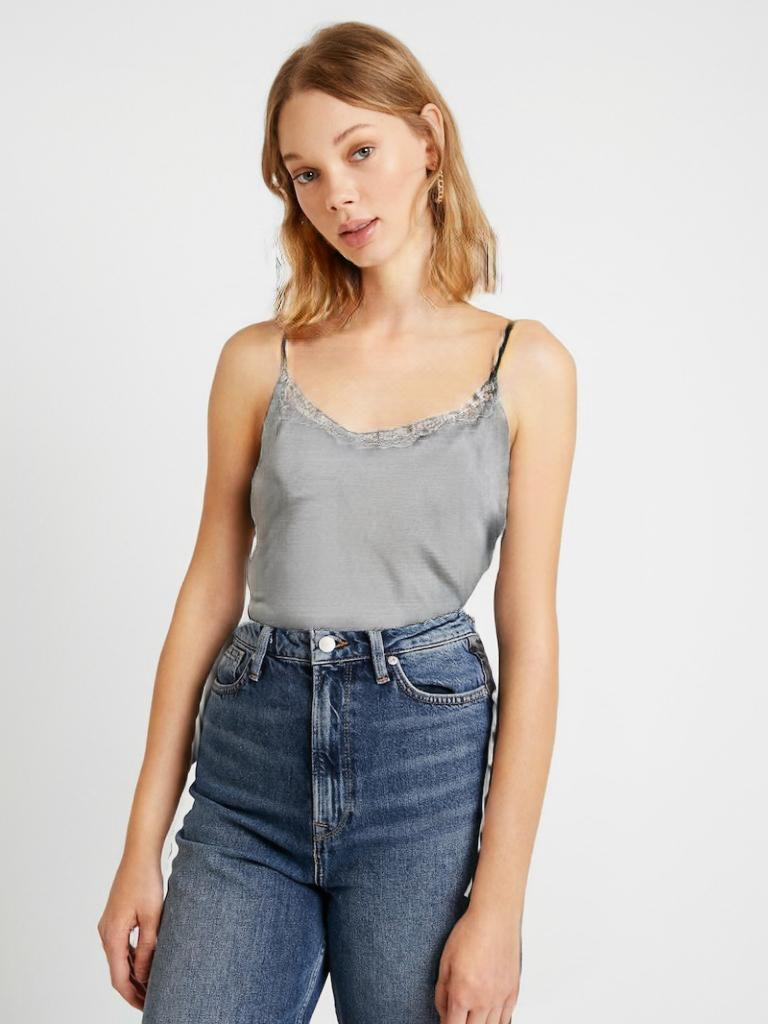

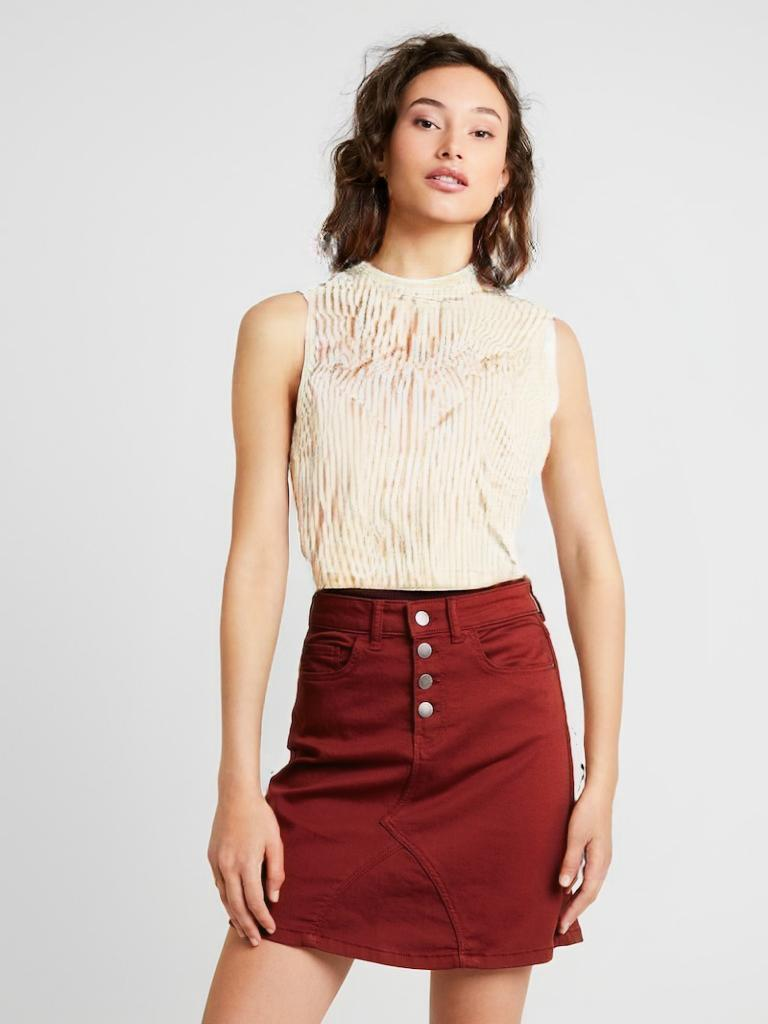

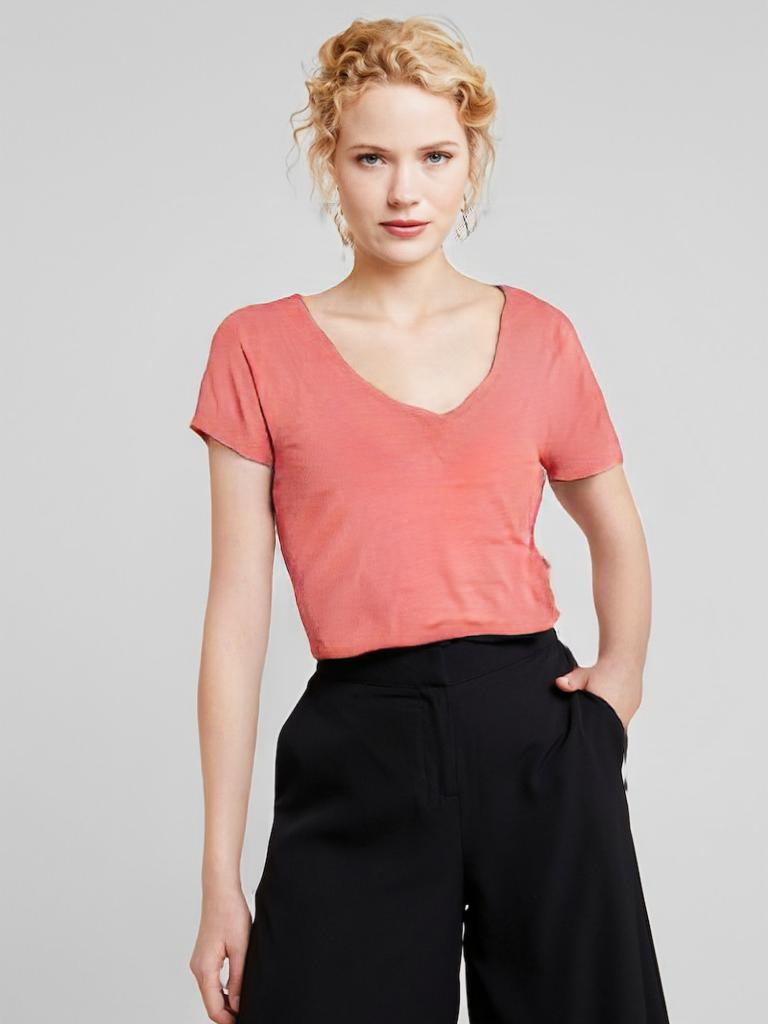

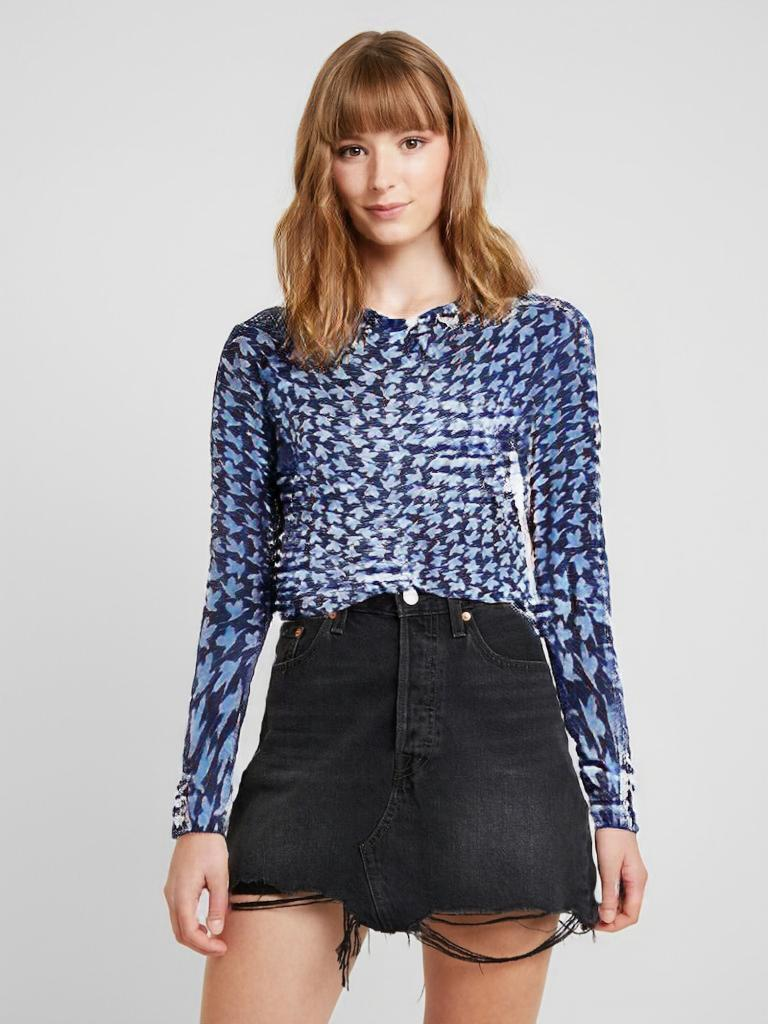

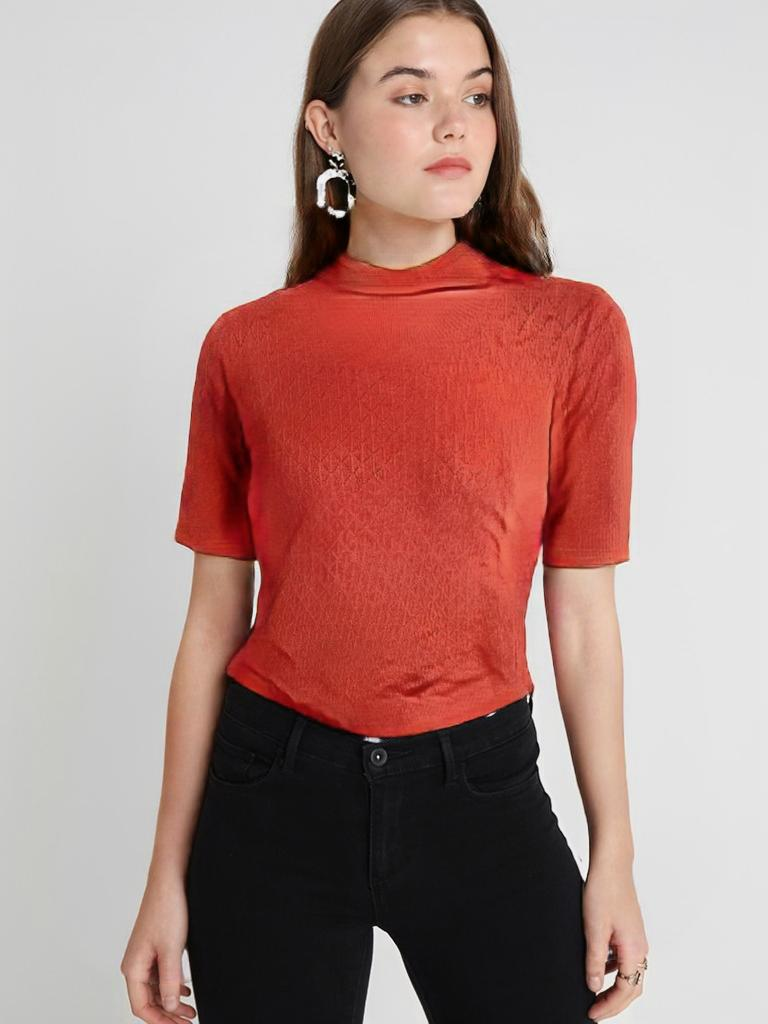

In [6]:
# Run test.py script for inference
%matplotlib inline
!CUDA_VISIBLE_DEVICES=0 python ./test.py --name "default_test"

# Path to the image directory
image_dir = "results/default_test"
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
max_per_row = 4

# Show images
if image_paths:
    for i in range(0, len(image_paths), max_per_row):
        images = [Image.open(img) for img in image_paths[i:i + max_per_row]]
        display(*images)  # Display images on the same line
else:
    print("No images found in the folder.")


In [7]:
# remove pre-used test files

folders_to_clear = [
    "datasets/test/cloth",
    "datasets/test/cloth-mask",
    "datasets/test/image",
    "datasets/test/image-parse",
    "datasets/test/openpose-img",
    "datasets/test/openpose-json"
]

# Rmove files from folders
for folder in folders_to_clear:
    if os.path.exists(folder):
        for item in os.listdir(folder):
            item_path = os.path.join(folder, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print(f"Empty: {folder}")
    else:
        print(f"Folder not found: {folder}")

print("Cleaning completed")


Empty: datasets/test/cloth
Empty: datasets/test/cloth-mask
Empty: datasets/test/image
Empty: datasets/test/image-parse
Empty: datasets/test/openpose-img
Empty: datasets/test/openpose-json
Cleaning completed


## Importing 100 images from zalando-HD-resized Dataset

The dataset containing all the files used for further evaluation of VITONHD is downloaded from Kaggle link:
https://www.kaggle.com/datasets/tinkukalluri/zalando-hd-resized

In [ ]:
colab_files.upload() #NOTE: a proprietary Kaggle API Key is to be uploaded here

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tinkukalluri/zalando-hd-resized

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tinkukalluri/zalando-hd-resized
License(s): MIT
100% 4.54G/4.54G [02:59<00:00, 28.2MB/s]
100% 4.54G/4.54G [02:59<00:00, 27.1MB/s]


In [9]:
# Fill in folders for tryon files from zalando-hd-resized dataset

zip_path = 'zalando-hd-resized.zip'
destinations = {
    'test/image/': 'datasets/test/image',
    'test/openpose_img/': 'datasets/test/openpose-img',
    'test/openpose_json/': 'datasets/test/openpose-json',
    'test/image-parse-v3/': 'datasets/test/image-parse',
    'test/cloth/': 'datasets/test/cloth',
    'test/cloth-mask/': 'datasets/test/cloth-mask'
}
num_files_per_category = 100  # Number of files to import

# Create dest folders if needed
for dest in destinations.values():
    os.makedirs(dest, exist_ok=True)

# File extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_groups = {key: [] for key in destinations.keys()}

    for file in sorted(zip_ref.namelist()):
        for prefix in destinations:
            if file.startswith(prefix):
                file_groups[prefix].append(file)
                break

    for prefix, files in file_groups.items():
        dest_folder = destinations[prefix]
        for file in files[:num_files_per_category]:
            dest_file = os.path.join(dest_folder, os.path.basename(file))
            with zip_ref.open(file) as source, open(dest_file, 'wb') as target:
                shutil.copyfileobj(source, target)

print("Completed")

Completed


In [ ]:
%matplotlib inline
!CUDA_VISIBLE_DEVICES=0 python ./test.py --name "original_tryon"

Namespace(name='original_tryon', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/content/VITON-HD/utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

In [ ]:
cartella_per_zippare = 'results/original_tryon'

# save path
percorso_zip = 'cartella_zippata.zip'

shutil.make_archive(percorso_zip.replace('.zip', ''), 'zip', cartella_per_zippare)

# Download zip file
from google.colab import files
files.download(percorso_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Validation of Pose Estimation and Segmentation in VITON-HD

To assess the accuracy of the pose estimation performed using OpenPose and the segmentation obtained via Self-Correction Human Parsing, we first load the images generated by the *OpenPose_PyTorch_for_VITON-HD.ipynb* and *Self-Correction_Human_Parsing_for_VITON-HD.ipynb* notebooks.  

A set of 100 images was selected to ensure a consistent evaluation of their performance within the VITON-HD pipeline.

*Notice, the set of images must be manually uploaded, and can be fully customized generating the parse masks and pose estimation json and image files from the notebooks.*


In [10]:
# Backup file before overwriting
def backup_directory(source_folder, backup_filename):
    if os.path.exists(source_folder):
        print(f"Creating backup: {backup_filename} ...")
        shutil.make_archive(backup_filename.replace('.zip', ''), 'zip', source_folder)
    else:
        print(f"Warning: {source_folder} does not exist. Skipping backup.")

# Creating backup zips
backup_directory('datasets/test/openpose-json', 'backup_json_original.zip')
backup_directory('datasets/test/openpose-img', 'backup_image_original.zip')
backup_directory('datasets/test/image-parse', 'backup_seg_original.zip')

Creating backup: backup_json_original.zip ...
Creating backup: backup_image_original.zip ...
Creating backup: backup_seg_original.zip ...


In [18]:
# upload zip files

def upload_and_extract(destination_folder, zip_file=None):
    if zip_file:
        print(f"Using provided file: {zip_file}")
        filename = zip_file
    else:
        uploaded = colab_files.upload()  # Upload zip
        filename = list(uploaded.keys())[0]

    if filename.endswith('.zip'):
        print(f"Extracting {filename} to {destination_folder} ...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        # os.remove(filename)  # Remove zip to save storage


## Pose Estimation and Segmentation testing

To evaluate the reliability of these pipeline steps, we perform testing on image-clothing pairs where the person in the image is already wearing the cloth. This allows us to extract meaningful metrics that quantify the accuracy and consistency of pose estimation and segmentation within VITON-HD.


In [19]:
def compute_ssim_color(image1, image2): # function to compute Structural Similarity

    ssim_r = ssim(image1[:, :, 0], image2[:, :, 0])
    ssim_g = ssim(image1[:, :, 1], image2[:, :, 1])
    ssim_b = ssim(image1[:, :, 2], image2[:, :, 2])

    return (ssim_r + ssim_g + ssim_b) / 3  # color channel avg

In [42]:
def compute_mean_ssim(original_path, generated_path):
    original_files = sorted(os.listdir(original_path))
    generated_files = sorted(os.listdir(generated_path))

    ssim_values = []

    for original_filename in original_files:
        base_name = "_".join(original_filename.split('_')[:-1])
        generated_filename = next((f for f in generated_files if f.startswith(base_name + '_')), None)

        if not generated_filename:
            continue

        img1 = cv2.imread(os.path.join(original_path, original_filename))
        img2 = cv2.imread(os.path.join(generated_path, generated_filename))

        if img1 is None or img2 is None or img1.shape != img2.shape:
            continue

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        ssim_values.append(np.mean([ssim(img1[:, :, i], img2[:, :, i], data_range=img1[:, :, i].max() - img1[:, :, i].min()) for i in range(3)]))

    return np.mean(ssim_values) if ssim_values else None

In [23]:
# Generating testing images references for our custom pipeline's testing

img_dir = "datasets/test/image"

image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))])
selected_images = image_files[:100]

# Generate config content
config_content = "\n".join(f"{img} {img}" for img in selected_images)

# test pairs path
config_path = "datasets/test_pairs.txt"

# Write selected pairs to test
with open(config_path, "w") as file:
    file.write(config_content)

print(f"Successfully overwritten: {config_path}")

Successfully overwritten: datasets/test_pairs.txt


In [46]:
# upload zip file of VITONHD tryon generated images

os.makedirs("results/original_tryon", exist_ok=True)

print("Upload original_tryon_100.zip:")
upload_and_extract("results/original_tryon")

Upload original_tryon.zip:


Saving original_tryon_100.zip to original_tryon_100 (1).zip
Extracting original_tryon_100 (1).zip to results/original_tryon ...


### Self-Correction Human Parsing evaluation

In [21]:
# Upload Self-Correction human parsing segmentation masks
print("Upload seg_processed_100.zip:")
upload_and_extract('datasets/test/image-parse')

Upload seg_processed.zip:


Saving seg_processed_100.zip to seg_processed_100.zip
Extracting seg_processed_100.zip to datasets/test/image-parse ...


In [24]:
%matplotlib inline
!CUDA_VISIBLE_DEVICES=0 python ./test.py --name "tryon_with_segmentation"

Namespace(name='tryon_with_segmentation', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/content/VITON-HD/utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute a

In [43]:
compute_mean_ssim("datasets/test/image", "results/tryon_with_segmentation")

0.86247195893745

### OpenPose pose estimation evaluation

In [31]:
# Upload OpenPose generations
print("Upload json_processed_100.zip:")
upload_and_extract('datasets/test/openpose-json')

print("Upload img_processed_100.zip:")
upload_and_extract('datasets/test/openpose-img')

# Restore original segmentation files
upload_and_extract('datasets/test/image-parse', 'backup_seg_original.zip')

Upload json_processed.zip:


Saving json_processed_100.zip to json_processed_100 (1).zip
Extracting json_processed_100 (1).zip to datasets/test/openpose-json ...
Upload image_processed.zip:


Saving img_processed_100.zip to img_processed_100.zip
Extracting img_processed_100.zip to datasets/test/openpose-img ...
Using provided file: backup_seg_original.zip
Extracting backup_seg_original.zip to datasets/test/image-parse ...


In [32]:
%matplotlib inline
!CUDA_VISIBLE_DEVICES=0 python ./test.py --name "tryon_with_openpose"

Namespace(name='tryon_with_openpose', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/content/VITON-HD/utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbit

In [44]:
compute_mean_ssim("results/original_tryon", "results/tryon_with_openpose")

0.9115108038331905

### Pose estimation + Self Correction

In [34]:
# Re-upload segmentation masks
upload_and_extract('datasets/test/image-parse', "seg_processed_100.zip") #CHECK IF ZIP FILE ALREADY PRESENT

Using provided file: seg_processed_100.zip
Extracting seg_processed_100.zip to datasets/test/image-parse ...


In [35]:
%matplotlib inline
!CUDA_VISIBLE_DEVICES=0 python ./test.py --name "tryon_with_pose_and_segmentation"

Namespace(name='tryon_with_pose_and_segmentation', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/content/VITON-HD/utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will 

In [45]:
compute_mean_ssim("results/original_tryon", "results/tryon_with_pose_and_segmentation")

0.8831026427664805

In [47]:
# Original VITONHD try-on mean_ssim
compute_mean_ssim("datasets/test/image", "results/original_tryon")

0.8618800340842934